# Анализ бизнес-показателей

Исследование проводится для **развлекательного приложения Procrastinate Pro+**. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Нам предоставлены данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
 
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Цель исследования - изучить:**

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Данные получены из файлов `visits_info_short.csv`, `orders_info_short.csv`, `costs_info_short.csv`. О качестве данных ничего не известно, поэтому перед началом анализа понадобится обзор данных.

## 1 Обзор и предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import numpy as np

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import plotly.express as px

In [2]:
# запись и чтение файлов
server_path_visits = '/datasets/visits_info_short.csv'   
server_path_orders = '/datasets/orders_info_short.csv'
server_path_costs = '/datasets/costs_info_short.csv' 


local_path_visits = 'visits_info_short.csv'   
local_path_orders = 'orders_info_short.csv'   
local_path_costs = 'costs_info_short.csv'   

try:
    visits = pd.read_csv(server_path_visits) 
    orders = pd.read_csv(server_path_orders)
    costs = pd.read_csv(server_path_costs)
except: 
    visits = pd.read_csv(local_path_visits)
    orders = pd.read_csv(local_path_orders)
    costs = pd.read_csv(local_path_costs)    

In [3]:
# функция для вывода информации по датафреймам
def info(data):
    data.info()
    display(data.head())
    print('Количество дубликатов:', data.duplicated().sum())

info(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

Количество дубликатов: 0


In [4]:
info(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

Количество дубликатов: 0


In [5]:
info(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Количество дубликатов: 0


**Описание данных**

В нашем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о покупках, а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`

- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура `orders_info_short.csv`

- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура `costs_info_short.csv`

- Channel — идентификатор рекламного источника,
- Dt — дата проведения рекламной кампании,
- Costs — расходы на эту кампанию.


Итак, прежде чем приступить к исследованию нужно привести в порядок данные. Мы приведем названия столбцов к строчному регистру и заменим типы данных в столбцах с датами, а именно в: `Session Start`, `Session End `, `Event Dt`, `dt`. Дубликаты в данных отсутствуют, пропуски тоже.

In [6]:
# приведение названий столбцов к нижнему регистру
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = costs.columns.str.lower()

In [7]:
# преобразование данных о времени для дальнейших расчетов
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

## 2 Запись функций для расчета и анализа LTV, ROI, удержания и конверсии

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
            

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## 3 Исследовательский анализ данных

### 3.1.  Создание пользовательских профилей. Определение минимальной и максимальной даты привлечения пользователей.


In [16]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

In [17]:
print('Минимальная дата привлечения пользователей:', profiles['dt'].min(),
     '\nМаксимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01 
Максимальная дата привлечения пользователей: 2019-10-27


**Вывод**

Мы создали пользовательские профили и выявили минимальную и максимальную дату привлечения пользователей: 2019-05-01 и 2019-10-27.

### 3.2. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [18]:
def group(data):
    data = profiles \
    .groupby(data) \
    .agg({'user_id':'count', 'payer':'sum'}) \
    .sort_values(by='payer', ascending=False) \
    .reset_index()
    
    data['perc'] = (data['payer'] / data['user_id'] * 100).round(2)  
    return data

group('region')

region  user_id  payer  perc
0  United States   100002   6902  6.90
1             UK    17575    700  3.98
2         France    17450    663  3.80
3        Germany    14981    616  4.11

In [19]:
fig = px.bar(group('region'), x='region', y=['user_id', 'payer'], title='Количество пользователей по странам')
fig.show()

**Вывод**

Мы видим, что больше всего платящих пользователей приходит из США, оттуда в целом приходит намного больше пользователй (100002), по сравнению с другими странами. Там же и наибольшая доля платящих пользователей почти 7%.

###  3.3 Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [20]:
group('device') 

device  user_id  payer  perc
0   iPhone    54479   3382  6.21
1  Android    35032   2050  5.85
2      Mac    30042   1912  6.36
3       PC    30455   1537  5.05

In [21]:
fig = px.bar(group('device') , x='device', y=['user_id', 'payer'], title='Устройства используемые клиентами')
fig.show()

**Вывод**

Больше всего платящих пользователей используют IPhone (всего - 54479, платящих- 3382), но , доля платящих пользователей играющих с Mac выше(всего - 30042, платящих - 1912).

### 3.4 Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [22]:
group('channel')

channel  user_id  payer   perc
0             FaceBoom    29144   3557  12.20
1               TipTop    19561   1878   9.60
2              organic    56439   1160   2.06
3       WahooNetBanner     8553    453   5.30
4           AdNonSense     3880    440  11.34
5       RocketSuperAds     4448    352   7.91
6              LeapBob     8553    262   3.06
7   OppleCreativeMedia     8605    233   2.71
8       lambdaMediaAds     2149    225  10.47
9              YRabbit     4312    165   3.83
10        MediaTornado     4364    156   3.57

In [23]:
fig = px.bar(group('channel'), x='channel', y=['user_id', 'payer'], title='Количество пользователей по источникам привлечения')
fig.show()

**Вывод**

Больше всего платящих пользователей приходят с FaceBoom(всего - 29144, платящих - 3557), меньше всего с MediaTornado(всего - 4364, платящих - 156). Самые большие доли платящих пользователей у FaceBoom(12,20%), AdNoneSence(11,34%) и lambdaMediaAds(10,47%). Но с последних двух в целом приходит мало пользователей, хоть и доля высокая.

## 4 Маркетинг

### 4.1. Общая сумма расходов на маркетинг. Распределение трат по источникам. Визуализация изменения метрик во времени.

In [24]:
print('Общая сумма расходов на маркетинг:', costs['costs'].sum().round(2))

Общая сумма расходов на маркетинг: 105497.3


In [25]:
costs['month'] = pd.DatetimeIndex(costs['dt']).month
ad_costs = costs.groupby(['month', 'channel']).agg({'costs':'sum'}).unstack('channel').reset_index()
ad_costs

month      costs                                                   \
channel       AdNonSense FaceBoom LeapBob MediaTornado OppleCreativeMedia   
0           5    1169.70   3524.4  140.28       238.56             169.75   
1           6     538.65   5501.1  314.58       138.00             370.00   
2           7     504.00   5294.3  313.53       138.48             366.50   
3           8     579.60   6274.4  369.81       154.56             439.25   
4           9     581.70   6114.9  343.98       144.72             427.75   
5          10     537.60   5736.5  315.42       140.16             378.00   

                                                                       
channel RocketSuperAds   TipTop WahooNetBanner YRabbit lambdaMediaAds  
0              577.980   2981.0          418.8  299.70          458.4  
1              325.715   6675.6          921.0  106.20          199.2  
2              252.070   8410.2          851.4   97.38          219.2  
3              253.110  11202.0         1040.4  124.74          220.0  
4              218.400  13232.5          977.4  152.79          247.2  
5              205.725  12250.0          942.0  163.41          213.6

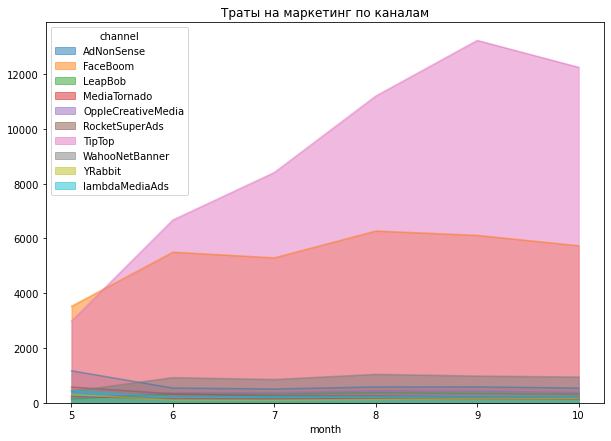

In [26]:
ad_costs.plot.area(x='month', y='costs', stacked=False, figsize=(10, 7), title='Траты на маркетинг по каналам')
plt.show()

In [27]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 4
)

In [28]:
# проверка

report = profiles.query(
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 27).date()'
)
print(
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), result_grouped['cohort_size'].sum()
    )
)

report = profiles.query(
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 27).date() and payer == True'
)
print(
    'Общее количество новых покупателей: {} {}'.format(
        len(report['user_id'].unique()),
        result_grouped.query('payer == True')['cohort_size'].sum(),
    )  
)

Общее количество новых пользователей: 150008 150008
Общее количество новых покупателей: 8881 8881


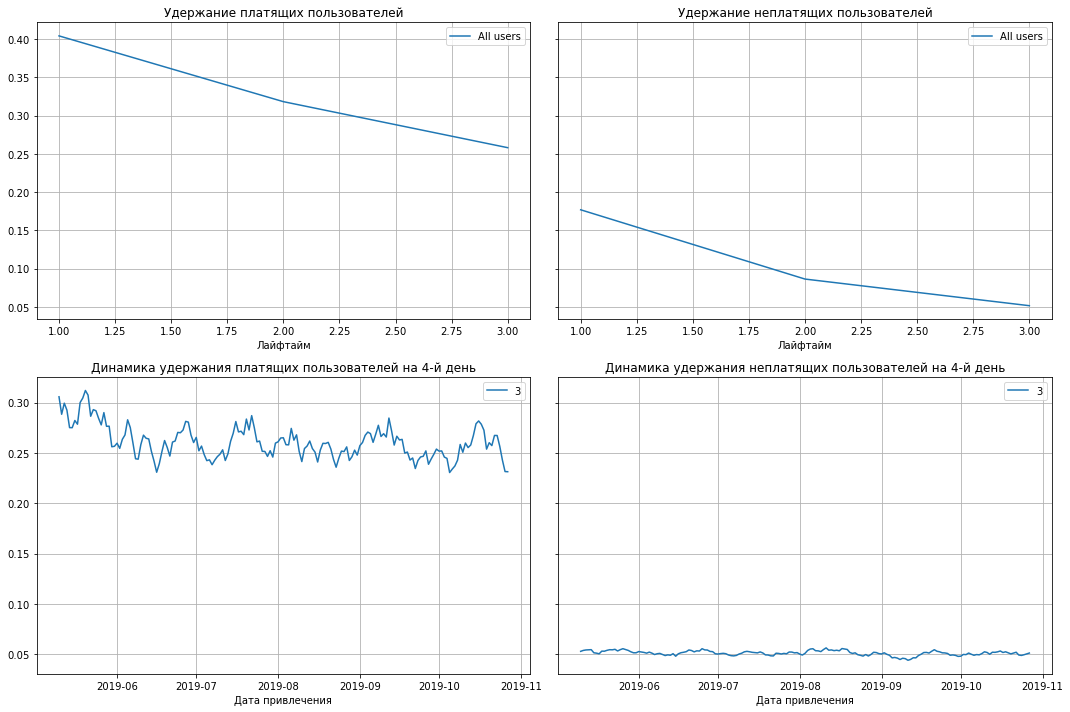

In [29]:
plot_retention(result_grouped, result_in_time, 4, window=10)

In [30]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 4
)

In [31]:
# проверка

report = profiles.query(
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 27).date()'
)
print(
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), result_grouped['cohort_size'].sum()
    )
)

Общее количество новых пользователей: 150008 150008


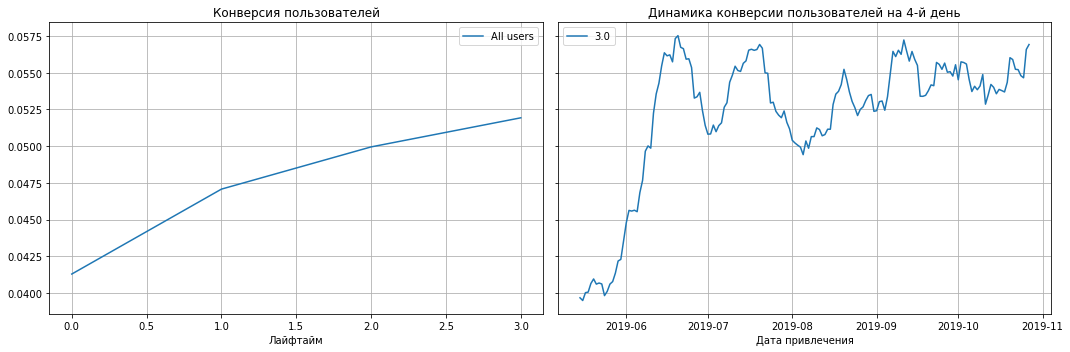

In [32]:
plot_conversion(result_grouped, result_in_time, 4, window=15)

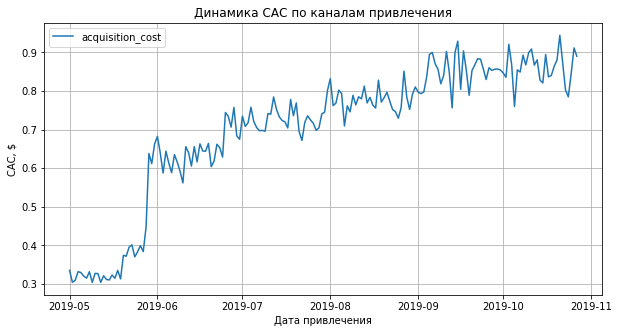

In [33]:
# график истории изменений CAC

profiles.pivot_table(
    index='dt', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

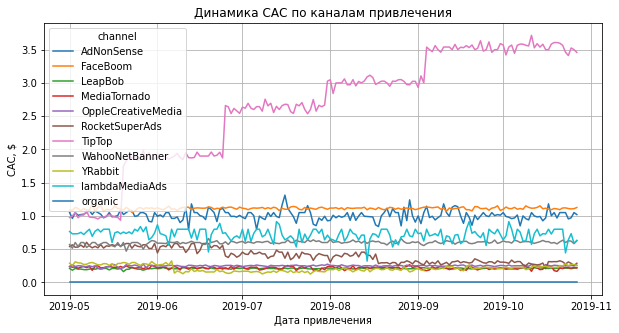

In [34]:
# график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

**Вывод**

Самые большие затраты приходятся на `TipTop` и состаляют половину всех затрат на рекламу. `FaceBoom` на втором месте по затратам, при том что с него приходит больше пользователей, и доля платящих пользователей выше, чем у TipTop.

Конверсия в мае-июне была значительно ниже, как и САС. Общий САС не достигает 1$.

САС AdNonSense примерно равна 1, чуть выше у FaceBoom. В то время как у TipTop растет с каждым месяцем и к концу иследуемого периода равна 3,5. C этим и связан рост общего САС без разбивки по каналам.



## 5 Оценка окупаемости рекламы

### 5.1. Анализ общей окупаемости рекламы. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [35]:
# исключим органических пользоввтелей из выборки
profiles_not_organic = profiles.query('channel != "organic"')

In [36]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_not_organic, orders, datetime(2019, 11, 1).date(), 14
)

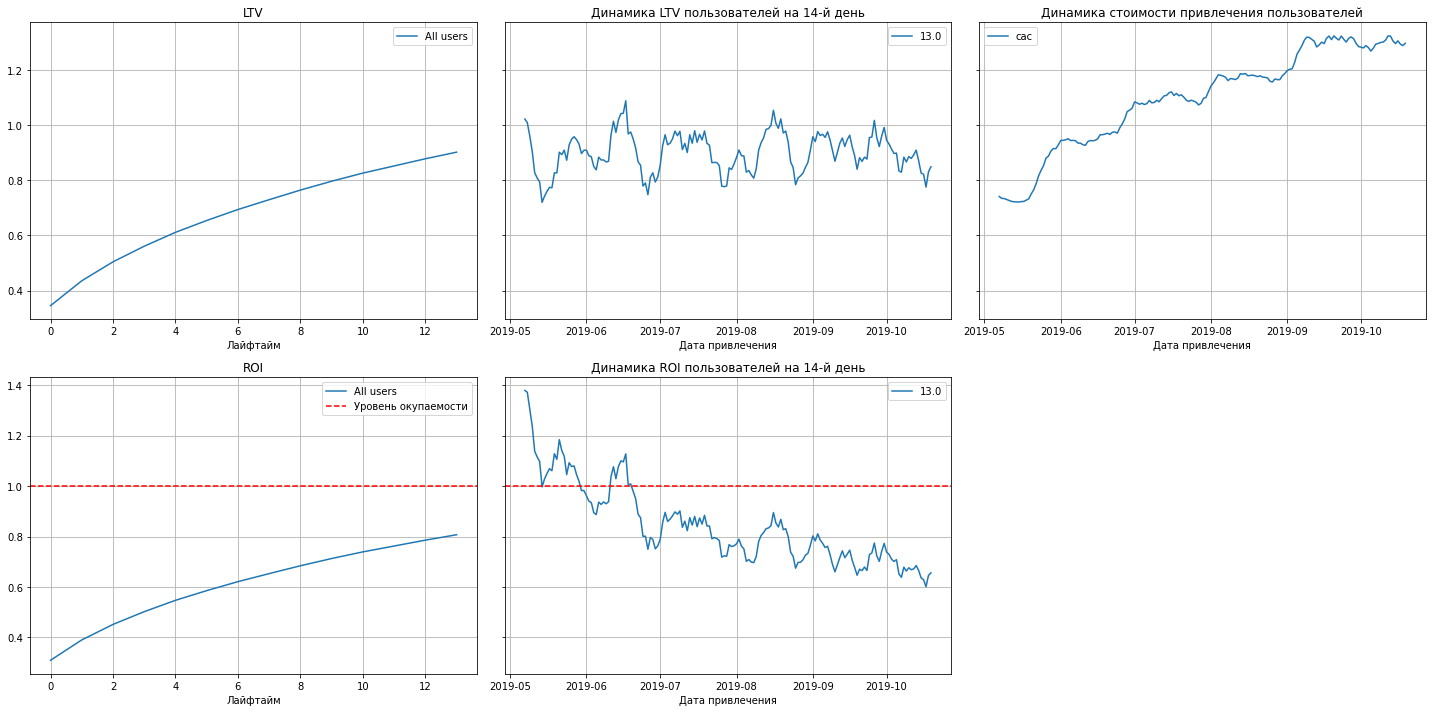

In [37]:
plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, 14, window=7)

**Вывод**

По графикам мы видим, что в целом реклама не окупается, тк стоимость привлечения пользователей сильно выросла с июня, в этом же месяце ROI опустился ниже порога окупаемости.

### 5.2. Анализ окупаемости рекламы с разбивкой по рекламным каналам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [38]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_not_organic, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

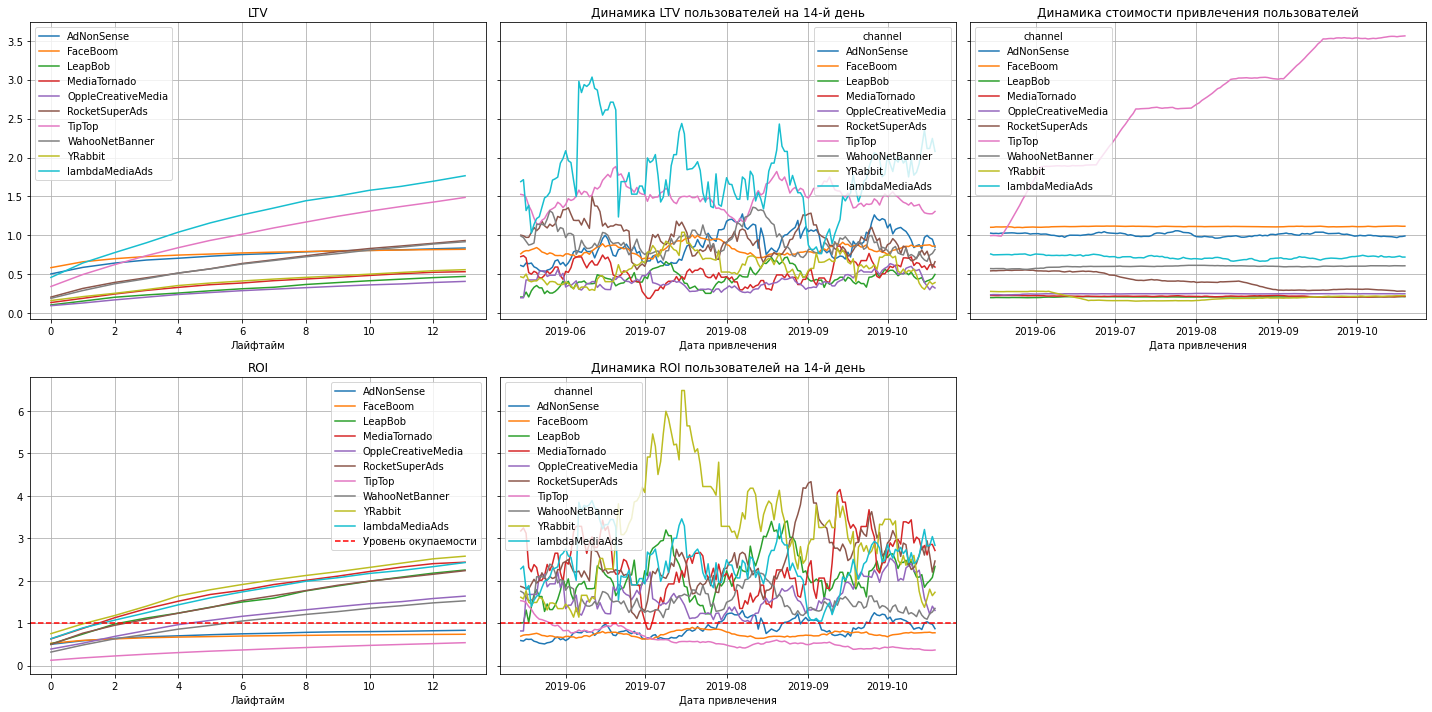

In [39]:
plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, 14, window=15)

**Вывод**

Благодаря разбивке по рекламным каналам мы видим, что наибольшая средняя выручка с пользователей у каналов lambdaMediaAds, TipTop. Стоимость привлчения пользователей через TipTop, значительно выше остальных каналов и растет с каждым месяцем. При этом ROI TipTop ниже уровня окупаемости, наряду с FaceBoom и LeapBob. Самый высокий ROI у YRabbit, MediaTornado и lambdaMediaAds.

### 5.3. Анализ окупаемости рекламы с разбивкой по странам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [40]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles_not_organic, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

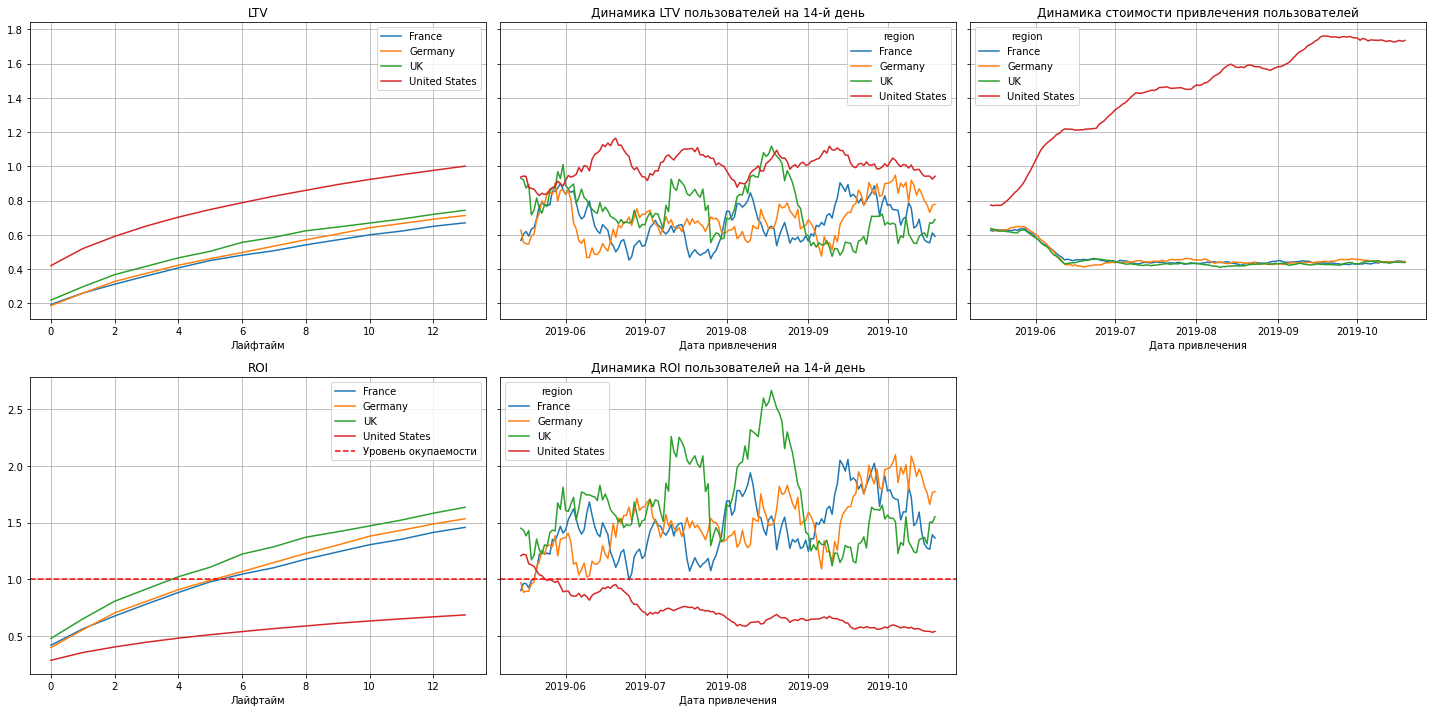

In [41]:
plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, 14, window=15)

**Вывод**

По графика видно, что реклама в США не окупается. Так же можно заметить, что стоимость привлечения пользователей из США намного выше. Если сопоставить с графиками с разбивкой по каналам, то можно предположить, что привлечением пользователей из США занимается рекламная капмпания TipTop.

### 5.4 Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам


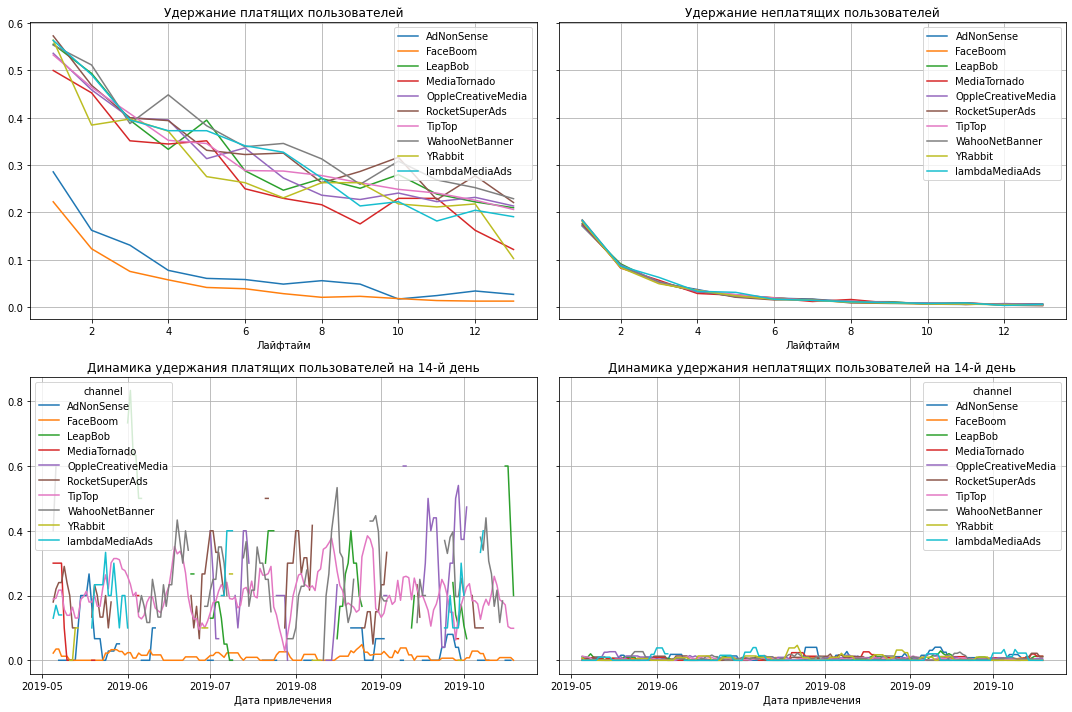

In [42]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles_not_organic, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

plot_retention(result_grouped, result_in_time, 14, window=5)

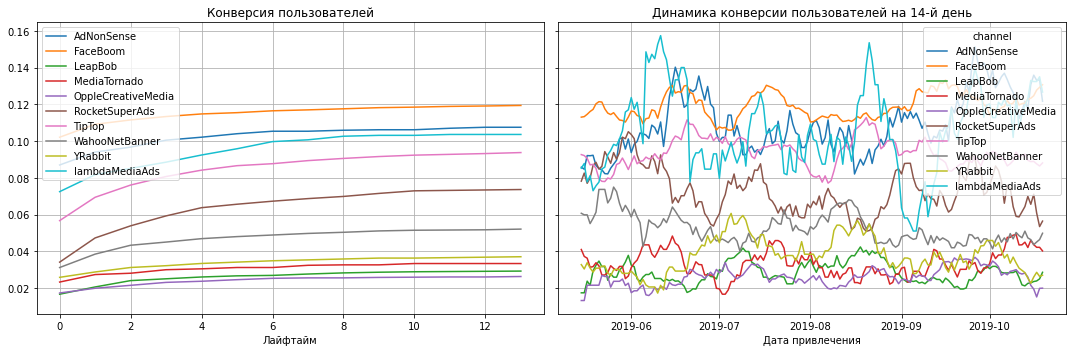

In [43]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles_not_organic, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

plot_conversion(result_grouped, result_in_time, 14, window=15)

**Вывод** 

Самые большие затраты приходятся на `TipTop` и состаляют половину всех затрат на рекламу. `FaceBoom` на втором месте по затратам, при том что с него приходит больше пользователей, и доля платящих пользователей выше, чем у TipTop. Удержание платящих пользователей FaceBoom слишком низкое, у других каналов Retention Rate намного выше. Удержание неплатящих пользователей у всех каналов одинаково.

Выделим несколько лидеров среди каналов по удержанию платящих пользоваталей: AdNonSense, TipTop и WahooNetBanner.
Через AdNonSense и WahooNetBanner приходит намного меньше пользователй, тк на эти каналы выделяется намного меньше средств, хотя конверсия AdNonSense, одна из самых высоких. Так же стоит выделить lambdaMediaAds, у этого канала тоже высокая конверсия пользователей, как и другие показатели выше.

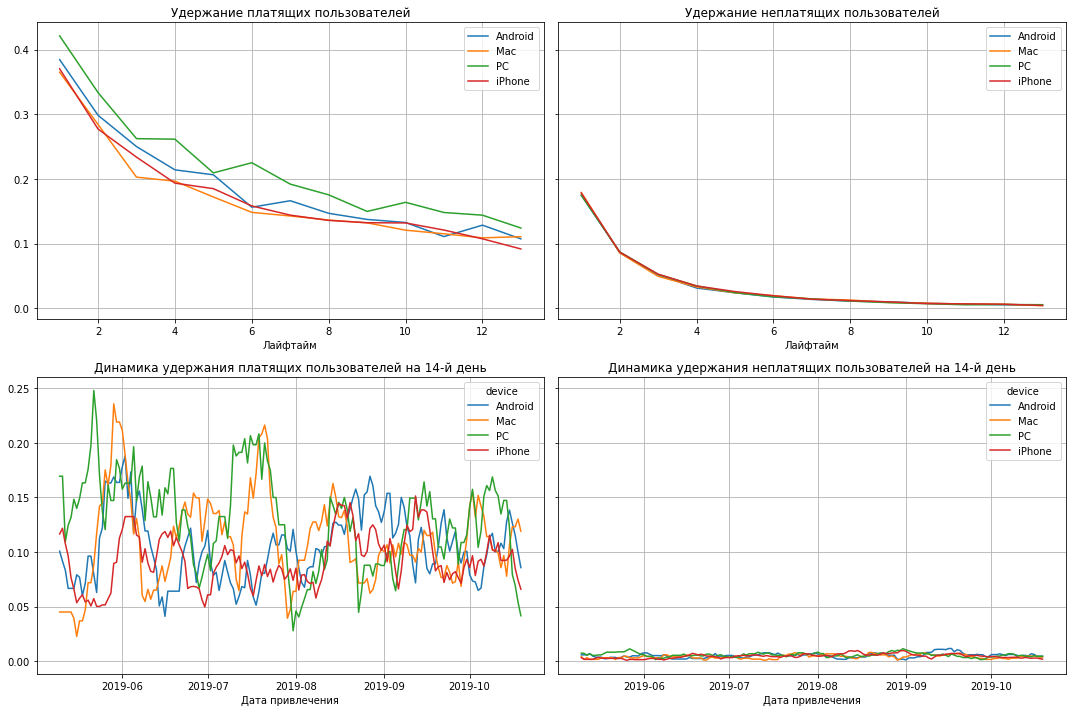

In [44]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles_not_organic, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plot_retention(result_grouped, result_in_time, 14, window=10)

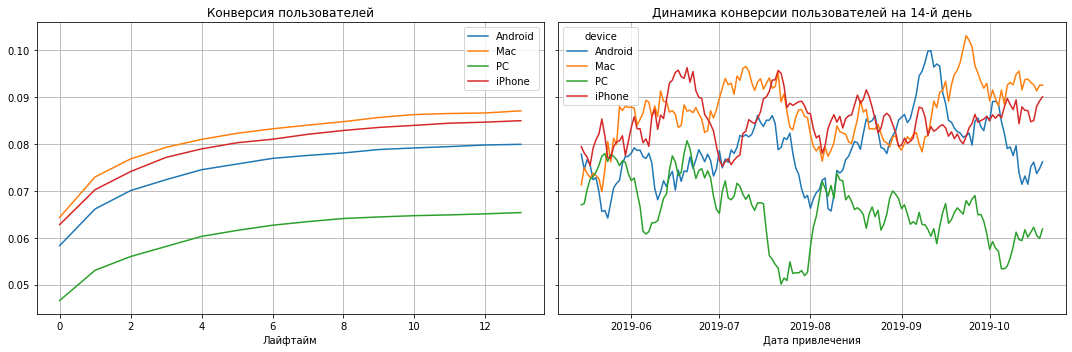

In [45]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles_not_organic, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plot_conversion(result_grouped, result_in_time, 14, window=15)

**Вывод**

Самое низкое удержание пользователей у Mac и IPhone, хотя конверсия их выше. Самая низкая конверсия у PC.

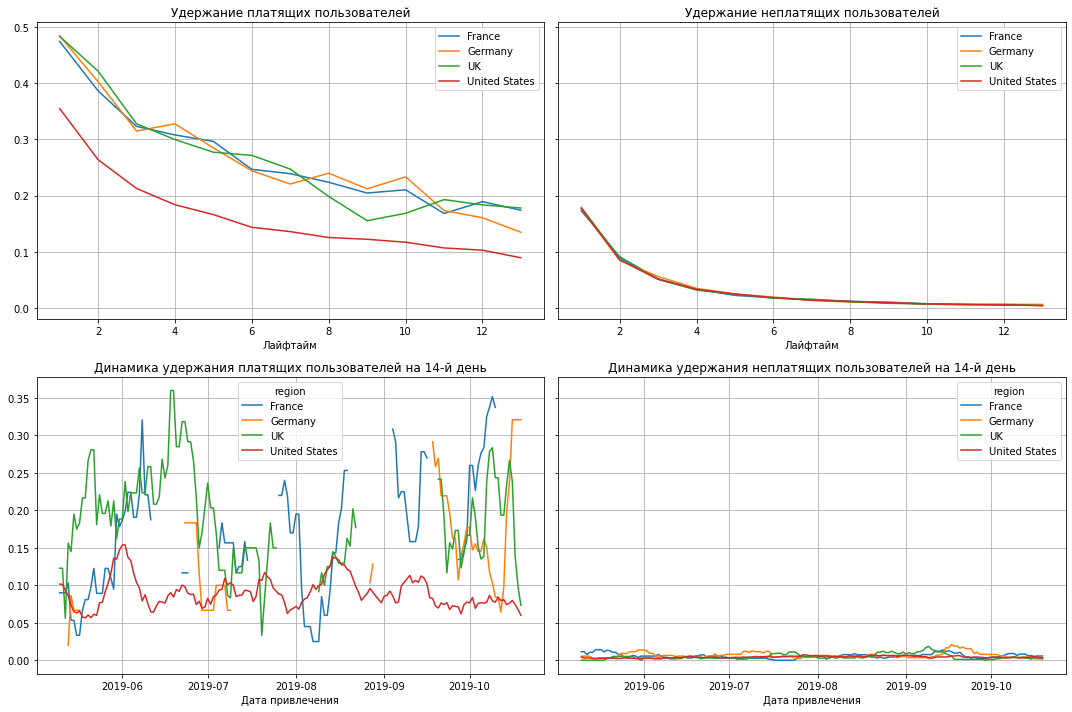

In [46]:
result_raw, result_grouped, result_in_time = get_retention(
    profiles_not_organic, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

plot_retention(result_grouped, result_in_time, 14, window=10)

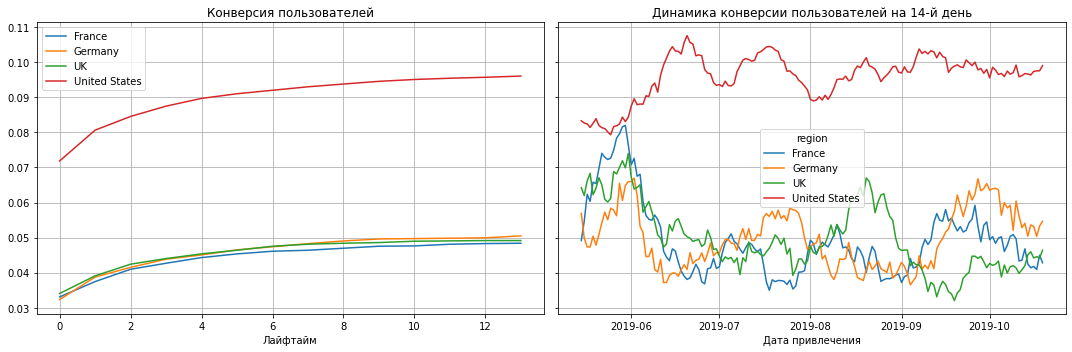

In [47]:
result_raw, result_grouped, result_in_time = get_conversion(
    profiles_not_organic, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

plot_conversion(result_grouped, result_in_time, 14, window=15)

**Вывод**

В США самое низкое удержание платящихпользователей, но самая высокая конверсия.

## Общие выводы

Перед началом анализа мы выполнили предобработку данных: изменили типы данных для значений времени, заменили на строчгый регистр названия столбцов. Дубликатови пропусаов в данных не было. 

Мы выяснили, что большинство пользоватлей **Procrastinate Pro+** из `USA` 100002 из них платящих 6,9%. Из `UK` 17575 пользователей (платящих 3,98%), `France` 17450 (платящих 3,80%), `Germany` 14981 (платящих 4,11%).

In [48]:
fig= px.pie(group('region'), values='user_id', names='region', title='Количество пользователей по странам')
fig.show()

In [49]:
fig= px.pie(group('region'), values='payer', names='region', title='Количество платящих пользователей по странам')
fig.show()

`В основном пользователи пользуются IPhone` (всего - 54479, платящих - 3382), Android	(35032, платящих - 2050), Mac (30042, всего - 1912), PC	(30455, платящих - 1537). Так же мы узнали, что пользователи у Mac самая высокая конверсия, следующий показатель у IPhone, самый низкий у PC.

`Самые большие затраты приходятся на TipTop` (54751.30) и состаляют половину всех затрат на рекламу (105497.3). `FaceBoom` (32445.60) на втором месте по затратам, при том что с него приходит больше пользователей, и доля платящих пользователей выше, чем у TipTop.

Конверсия в мае-июне была значительно ниже, как и САС. Общий САС не достигает 1$.

САС AdNonSense примерно равна 1, чуть выше у FaceBoom. В то время как у TipTop увеличивается с каждым месяцем и к концу иследуемого периода равна 3,5. C этим и связан рост общего САС без разбивки по каналам.

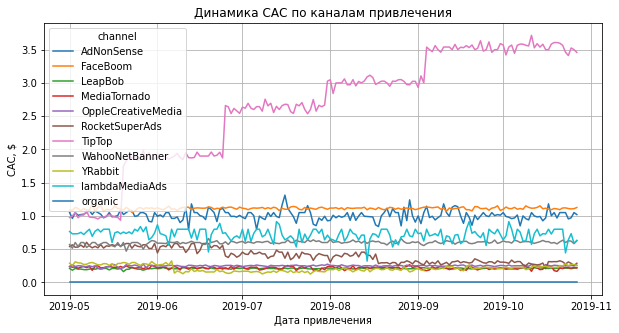

In [50]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

`Наибольшая средняя выручка с пользователей у каналов lambdaMediaAds, TipTop`. Стоимость привлчения пользователей через TipTop, значительно выше остальных каналов и растет с каждым месяцем. При этом ROI TipTop ниже уровня окупаемости, наряду с FaceBoom и LeapBob. Самый высокий ROI у YRabbit, MediaTornado и lambdaMediaAds.

**Итоги**:
- В целом реклама не окупается. Это связано с высокой стоимостью привлчения пользователей из США через рекламу TipTop. На этот канал уходит половина рекламного бюджета. Так же следует обратить внимание на FaceBoom, воторой по затратам канал, там слишком низкий показатель удержания платящих пользователей. LeapBob так же не окупается.
- Платящие пользователи из США удерживаются хуже всего. 
- Удержание плаятщих пользователей Mac и IPhone, ниже других. Конверсия PC так же слишком низкая.

**Рекомендации**

- Следует пересмотреть рекламную кампанию в США. Рекомендуем отказаться от рекламы в TipTop, из-за высокой стоимости привлечения. Обратить внимание на lambdaMediaAds, у него так же одна из самых больших долей платящих пользователей. Потом возможно отказаться от FaceBoom и LeapBob, тк они тоже не окупаются 
- Скорректировать интерфейс для PC, из-за низкой конверсии пользователей. Поработать над удеражнием пользователй IPhone, ведь таких пользователй больше.